In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. VERİ YÜKLEME
df = pd.read_csv("gym_members_exercise_tracking.csv")
X = df.drop('Workout_Type', axis=1)
y = df['Workout_Type']

# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df["Gender_Code"] = le_gender.fit_transform(df["Gender"])
y = le_workout.fit_transform(y)

print(f"Sınıflar encode edildi: {dict(zip(le_workout.classes_, range(len(le_workout.classes_))))}")

# print(f"\nVeri seti boyutu: {df.shape}")
# print(f"\nGender dağılımı:\n{df['Gender'].value_counts()}")
# print(f"\nExperience Level dağılımı:\n{df['Experience_Level'].value_counts().sort_index()}")

print(f"Veri boyutu: X={X.shape}, y={y.shape}")
print(f"Sınıf dağılımı: {np.bincount(y)}")

Sınıflar encode edildi: {'Cardio': 0, 'HIIT': 1, 'Strength': 2, 'Yoga': 3}
Veri boyutu: X=(973, 14), y=(973,)
Sınıf dağılımı: [255 221 258 239]


In [3]:
# Feature Engineering
df["HR_per_minute"] = df["Avg_BPM"] / (df["Session_Duration (hours)"] * 60)
df["Intensity_per_Weight"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
df["Efficiency"] = df["Calories_Burned"] / df["Avg_BPM"]
df["Experience_Adjusted_Calories"] = df["Calories_Burned"] / (df["Experience_Level"] + 1)
df["Anaerobic_Index"] = (df["Max_BPM"] - df["Avg_BPM"]) / df["Resting_BPM"]
df["BPM_Variance_Rest"] = (df["Avg_BPM"] - df["Resting_BPM"]) ** 2
df["Heart_Instability"] = abs(df["Max_BPM"] - df["Avg_BPM"]) / df["Max_BPM"]
df["Calories_per_Hour"] = df["Calories_Burned"] / df["Session_Duration (hours)"]
df["Heart_Efficiency"] = df["Calories_Burned"] / df["HRR"]
df["BMI_Category"] = pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df["Age_Group"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)

In [4]:
# Feature Selection - Workout_Code'u ÇIKAR!
numerical_cols = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level',
    'BMI', 'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Experience_Adjusted_Calories', 'Anaerobic_Index',
    'BPM_Variance_Rest', 'Heart_Instability', 'Calories_per_Hour',
    'Heart_Efficiency', 'BMI_Category', 'Age_Group'
]

# X tanımlama - Workout_Code'suz
X = df[numerical_cols]

In [5]:
# 2. VERİ BÖLME (Eğitim ve Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")


Eğitim seti boyutu: (778, 25)
Test seti boyutu: (195, 25)


In [6]:
# 3. ÖZELLİK ÖLÇEKLENDİRME
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# 4. SVM MODELİ OLUŞTURMA VE EĞİTİM

# Basit model
print("\n--- Basit SVM Modeli ---")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred = svm_model.predict(X_test_scaled)


--- Basit SVM Modeli ---



Doğruluk Skoru: 0.2410

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.20      0.24      0.22        51
           1       0.25      0.11      0.16        44
           2       0.30      0.40      0.34        52
           3       0.20      0.19      0.20        48

    accuracy                           0.24       195
   macro avg       0.24      0.24      0.23       195
weighted avg       0.24      0.24      0.23       195


Confusion matrix 'confusion_matrix.png' olarak kaydedildi.


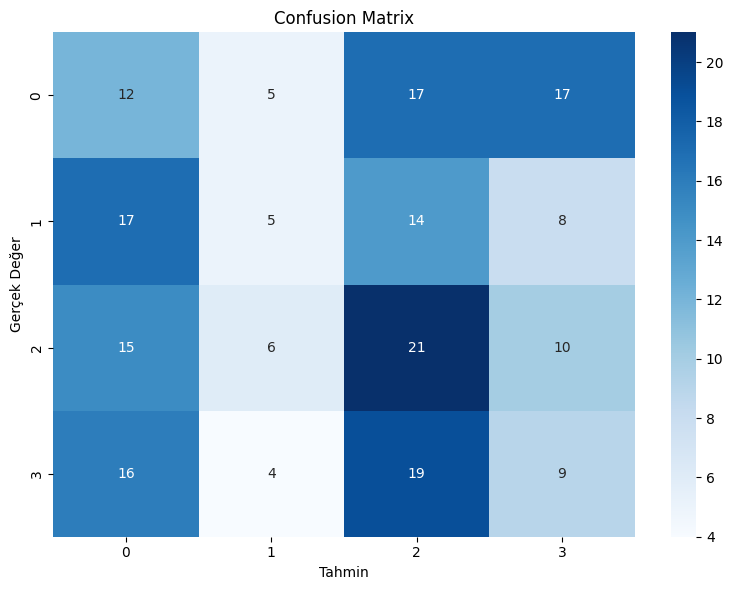

In [8]:
# 5. MODEL DEĞERLENDİRME
print(f"\nDoğruluk Skoru: {accuracy_score(y_test, y_pred):.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300)
print("\nConfusion matrix 'confusion_matrix.png' olarak kaydedildi.")

In [9]:
# 6. HİPERPARAMETRE OPTİMİZASYONU (Grid Search)
print("\n--- Hiperparametre Optimizasyonu Başlıyor ---")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
print(f"En iyi cross-validation skoru: {grid_search.best_score_:.4f}")

# En iyi modeli test et
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

print(f"\nOptimize edilmiş model test doğruluğu: {accuracy_score(y_test, y_pred_best):.4f}")


--- Hiperparametre Optimizasyonu Başlıyor ---
Fitting 5 folds for each of 60 candidates, totalling 300 fits

En iyi parametreler: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
En iyi cross-validation skoru: 0.2854

Optimize edilmiş model test doğruluğu: 0.2308



--- Farklı Kernel'lar Karşılaştırılıyor ---
Linear Kernel Doğruluğu: 0.2154
Rbf Kernel Doğruluğu: 0.2410
Poly Kernel Doğruluğu: 0.2667
Sigmoid Kernel Doğruluğu: 0.2256

Kernel karşılaştırması 'kernel_comparison.png' olarak kaydedildi.


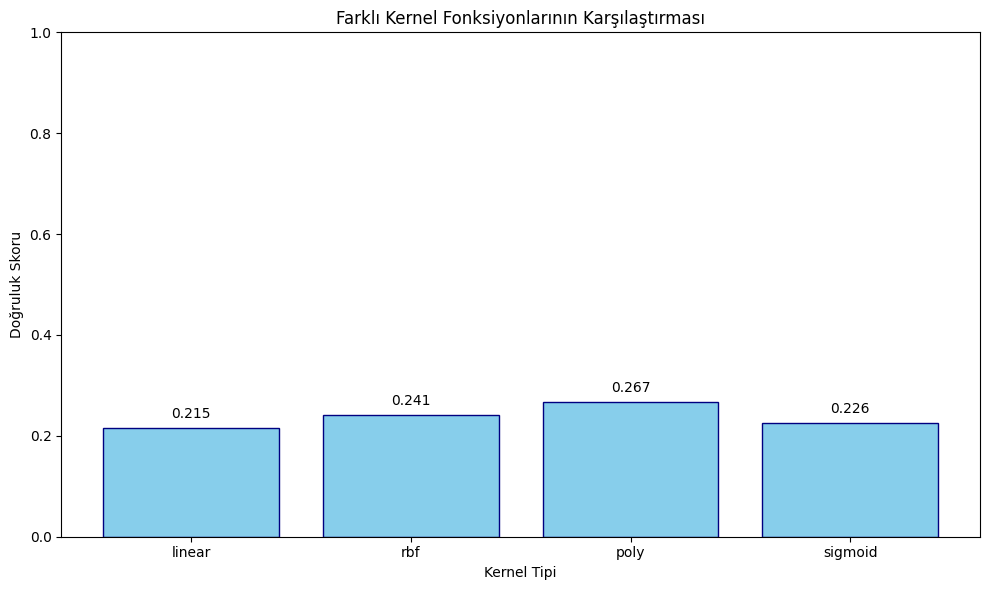

In [10]:
# 7. FARKLI KERNEL'LARIN KARŞILAŞTIRILMASI
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = {}

print("\n--- Farklı Kernel'lar Karşılaştırılıyor ---")
for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    results[kernel] = score
    print(f"{kernel.capitalize()} Kernel Doğruluğu: {score:.4f}")

# Sonuçları görselleştir
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue', edgecolor='navy')
plt.title('Farklı Kernel Fonksiyonlarının Karşılaştırması')
plt.xlabel('Kernel Tipi')
plt.ylabel('Doğruluk Skoru')
plt.ylim([0, 1])
for i, (k, v) in enumerate(results.items()):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.savefig('svm_kernel_comparison.png', dpi=300)
print("\nKernel karşılaştırması 'kernel_comparison.png' olarak kaydedildi.")

In [11]:
# 8. MODELİ KAYDETME
#import joblib
#joblib.dump(best_model, 'svm_model.pkl')
#joblib.dump(scaler, 'scaler.pkl')
#print("\nModel 'svm_model.pkl' ve scaler 'scaler.pkl' olarak kaydedildi.")


Model 'svm_model.pkl' ve scaler 'scaler.pkl' olarak kaydedildi.
